## Data and equation solving

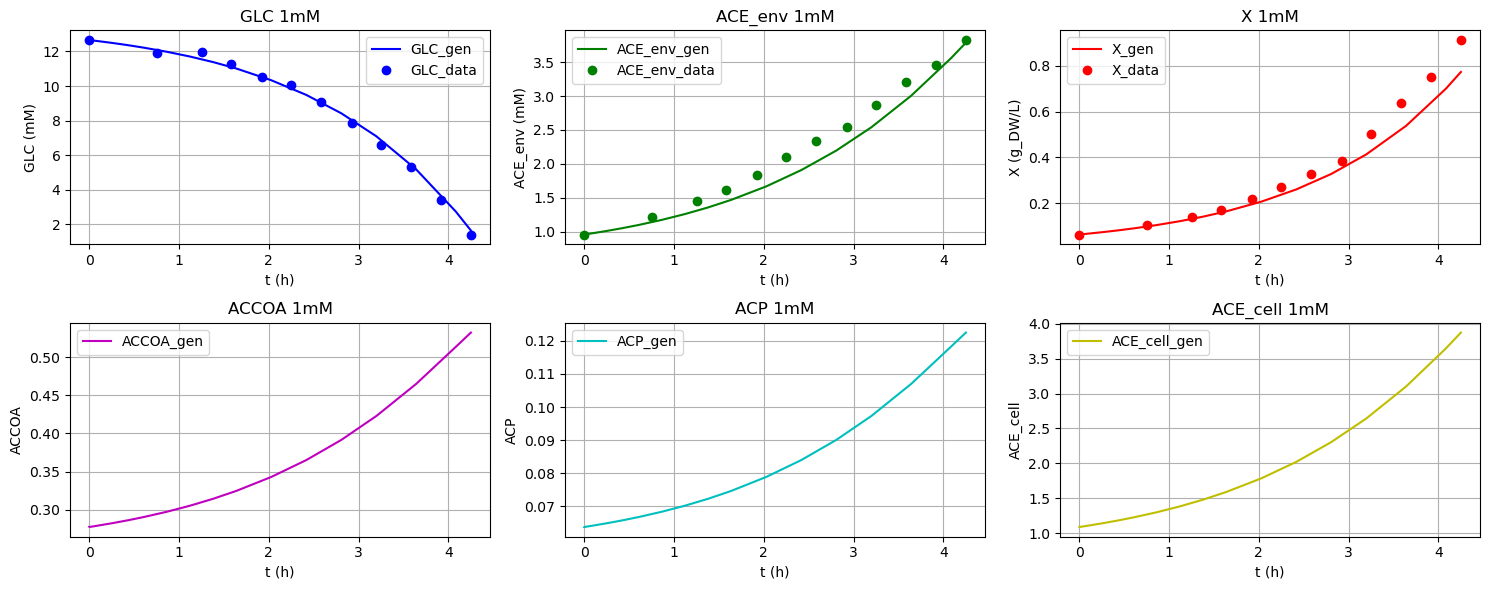

In [1]:
# Solving the ODE system for 1mM
from Millard_dict import DICT
from scipy.integrate import solve_ivp
from deriv_equations_Millard import deriv_Millard
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt

# Initial conditions
GLC_1_0 = 12.6597333333333
ACE_env_1_0 = 0.958577777777778
X_1_0 = 0.06308

# These initial conditions were found intuitively
ACCOA_1_0 = 0.27745
ACP_1_0 = 0.06377
ACE_cell_1_0 = 1.0874

# Initial conditions vector
y_1_0 = [GLC_1_0, ACE_env_1_0, X_1_0, ACCOA_1_0, ACP_1_0, ACE_cell_1_0] 

res = solve_ivp(fun=deriv_Millard,
                t_span=(0,4.25),
                y0=y_1_0,
                method='LSODA',
                args=(DICT,))

GLC, ACE_env, X, ACCOA, ACP, ACE_cell = res.y

# Load experimental data 
data_1 = genfromtxt('data_1mM.csv', delimiter=',')
data_t_1 = data_1[1:, 0]  

# Constructing the figure

fig, axs = plt.subplots(2, 3, figsize=(15, 6))

axs[0,0].plot(res.t, GLC, label='GLC_gen', color='b')
axs[0,0].plot(data_t_1, data_1[1:, 3], 'o', label='GLC_data', color='b')
axs[0,0].set_title('GLC 1mM')
axs[0,0].set_xlabel('t (h)')
axs[0,0].set_ylabel('GLC (mM)')
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].plot(res.t, ACE_env, label='ACE_env_gen', color='g')
axs[0,1].plot(data_t_1, data_1[1:, 1], 'o', label='ACE_env_data', color='g')
axs[0,1].set_title('ACE_env 1mM')
axs[0,1].set_xlabel('t (h)')
axs[0,1].set_ylabel('ACE_env (mM)')
axs[0,1].legend()
axs[0,1].grid(True)

axs[0,2].plot(res.t, X,label='X_gen', color='r')
axs[0,2].plot(data_t_1, data_1[1:, 2], 'o',label='X_data', color='r')
axs[0,2].set_title('X 1mM')
axs[0,2].set_xlabel('t (h)')
axs[0,2].set_ylabel('X (g_DW/L)')
axs[0,2].legend()
axs[0,2].grid(True)

axs[1,0].plot(res.t, ACCOA, label='ACCOA_gen', color='m')
axs[1,0].set_title('ACCOA 1mM')
axs[1,0].set_xlabel('t (h)')
axs[1,0].set_ylabel('ACCOA')
axs[1,0].legend()
axs[1,0].grid(True)

axs[1,1].plot(res.t, ACP, label='ACP_gen', color='c')
axs[1,1].set_title('ACP 1mM')
axs[1,1].set_xlabel('t (h)')
axs[1,1].set_ylabel('ACP')
axs[1,1].legend()
axs[1,1].grid(True)

axs[1,2].plot(res.t, ACE_cell,label='ACE_cell_gen', color='y')
axs[1,2].set_title('ACE_cell 1mM')
axs[1,2].set_xlabel('t (h)')
axs[1,2].set_ylabel('ACE_cell')
axs[1,2].legend()
axs[1,2].grid(True)

plt.tight_layout()
plt.show()

In [2]:
# Export generated data from ODE solving
generated_Millard_data = np.asarray([res.t, GLC, ACE_env, X, ACCOA, ACP, ACE_cell]) 
np.savetxt("test_generated_Millard_data.csv", generated_Millard_data, delimiter=",")

In [3]:
#load generated data
ode_data_1 = genfromtxt('test_generated_Millard_data.csv', delimiter=',') # in the form [t, GLC, ACE_env, X, ACCOA, ACP, ACE_cell]

## Neural Network Training for initial ACE 1mM

In [4]:
# Training parameters 
learning_rate = 1e-4
# epoch_number = 500000
# epoch_number = 50000
epoch_number = 100000

# Scheduler parameters (unused right now)
Base_LR = 1e-4
Max_LR = 1e-4
Step_Size_Up = 100
Mode = "exp_range"
Gamma = 0.999
Cycle_Momentum = False

In [5]:
# Setting variables (known and unknown), parameters, parameters ranges, constants 
import random
from tools import random_ranges

random.seed(42)

variables = ["GLC","ACE_env","X","ACCOA","ACP","ACE_cell"]
variable_data = {v : ode_data_1[i+1] for i,v in enumerate(variables)}
variable_no_data  = {}
#variable_no_data  = {"ACCOA":None,"ACP":None,"ACE_cell":None}
data_t = res.t
residual_weights=[1,1,1,1e-13,1e-14,1e-7]

parameter_names = ["v_max_glycolysis"]
#parameter_names = ["v_max_AckA", "v_max_Pta", "v_max_glycolysis", "Ki_ACE_glycolysis", "Km_ACCOA_TCA_cycle", "v_max_TCA_cycle", "Ki_ACE_TCA_cycle", "Y", "v_max_acetate_exchange", "Km_ACE_acetate_exchange"]

true_parameters=[]
for key in parameter_names:
    true_parameters.append(DICT[key])

ranges = random_ranges(true_parameters,scale=20)
constants_dict = DICT

In [6]:
# Create the PINN
import torch
import torch.optim as optim
from pinn import Pinn
from deriv_equations_Millard import ODE_residual_dict_Millard

torch.manual_seed(42)

pinn_cell = Pinn(ode_residual_dict=ODE_residual_dict_Millard,
                 ranges=ranges,
                 data_t=data_t,
                 variables_data=variable_data,
                 variables_no_data=variable_no_data,
                 parameter_names=parameter_names,
                 constants_dict=constants_dict,
                 residual_weights=residual_weights
                 )

In [7]:
# Training
optimizer = optim.Adam(
    pinn_cell.params,
    lr = learning_rate
    )
pinn_cell.optimizer = optimizer

# Scheduler disabled when Max_LR = Base_LR
scheduler = torch.optim.lr_scheduler.CyclicLR(
    pinn_cell.optimizer,
    base_lr=Base_LR,
    max_lr=Max_LR,
    step_size_up=Step_Size_Up,
    mode=Mode,
    gamma=Gamma,
    cycle_momentum=Cycle_Momentum
    )
pinn_cell.scheduler = scheduler


r2_store, pred_variables, losses, variable_fit_losses, residual_losses, learned_parameters, learning_rates = pinn_cell.train(epoch_number)
GLC_pred, ACE_env_pred, X_pred, ACCOA_pred, ACP_pred, ACE_cell_pred  = pred_variables


starting training...


Epoch  0
#################################

Epoch  1000
#################################

Epoch  2000
#################################

Epoch  3000
#################################

Epoch  4000
#################################

Epoch  5000
#################################

Epoch  6000
#################################

Epoch  7000
#################################

Epoch  8000
#################################

Epoch  9000
#################################

Epoch  10000
#################################

Epoch  11000
#################################

Epoch  12000
#################################

Epoch  13000
#################################

Epoch  14000
#################################

Epoch  15000
#################################

Epoch  16000
#################################

Epoch  17000
#################################

Epoch  18000
#################################

Epoch  19000
#################################

Epoch  20000
################

## Assessment

In [8]:
save_fig_choice = False
path_to_save = 'enter_path'

# save_fig_choice = True
# path_to_save = './test/'


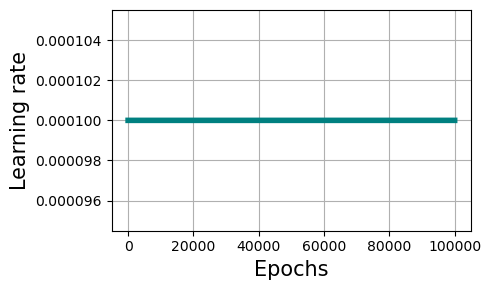

In [9]:
# Print and Plot learning rate
plt.figure(figsize=(5,3))
plt.plot(learning_rates[0:], color = 'teal',linewidth=4)
plt.grid(True)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Learning rate',fontsize=15)

plt.tight_layout()

plt.show()

Loss:  0.065001


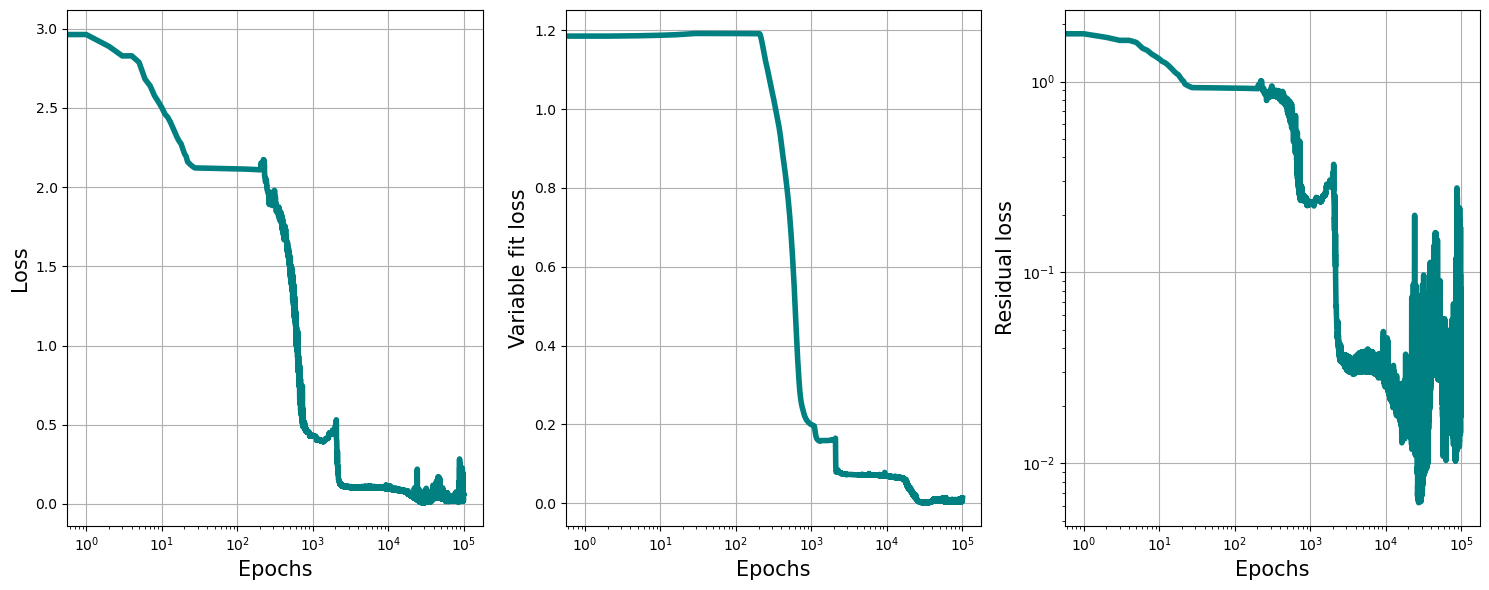

In [10]:
# Print and Plot Losses
print("Loss: ","%.5g" % losses[-1])

fig, axs = plt.subplots(1, 3, figsize=(15, 6))

axs[0].plot(losses[0:], color = 'teal',linewidth=4)
axs[0].grid(True)
axs[0].set_xlabel('Epochs',fontsize=15)
axs[0].set_ylabel('Loss',fontsize=15)
axs[0].set_xscale('log')

axs[1].plot(variable_fit_losses[0:], color = 'teal',linewidth=4)
axs[1].grid(True)
axs[1].set_xlabel('Epochs',fontsize=15)
axs[1].set_ylabel('Variable fit loss',fontsize=15)
axs[1].set_xscale('log')

axs[2].plot(residual_losses[0:], color = 'teal',linewidth=4)
axs[2].grid(True)
axs[2].set_xlabel('Epochs',fontsize=15)
axs[2].set_ylabel('Residual loss',fontsize=15)
axs[2].set_xscale('log')
axs[2].set_yscale('log')



plt.tight_layout()

fig_name = 'loss_short'
if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

r2 : 0.23593


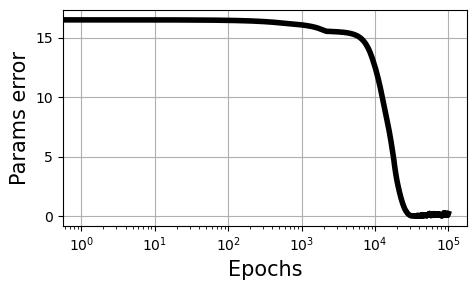

In [11]:
# Print and Plot R2 
# print(np.round(r2_store[-1],2))
print("r2 :","%.5g" % r2_store[-1])

plt.figure(figsize=(5,3))
plt.plot(r2_store, color = 'black',linewidth=4)
plt.grid(True)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Params error',fontsize=15)
plt.xscale('log')

plt.tight_layout()

fig_name = 'error_short'
if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_9100\2704877340.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(ranges))  # Get a colormap with as many colors as there are ranges


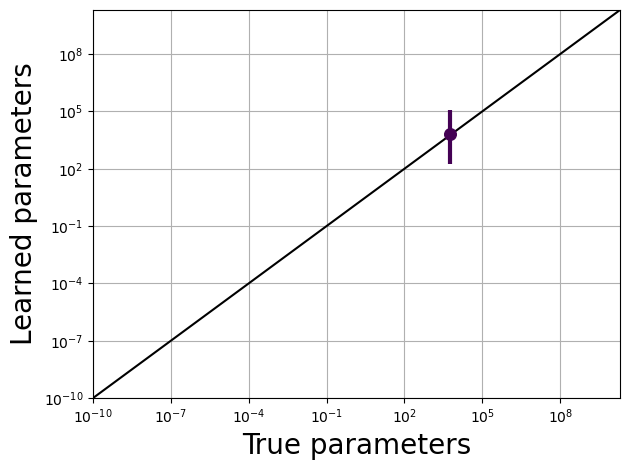

In [12]:
# Comparing parameters
learned_parameters = [pinn_cell.output_param_range(v,i).item() for (i,(k,v)) in enumerate(pinn_cell.ode_parameters.items())]

plt.grid('true')
plt.plot([0, 2*10**10], [0, 2*10**10],color='black')
plt.scatter(true_parameters,learned_parameters)
plt.xscale('log')
plt.yscale('log')

cmap = plt.cm.get_cmap('viridis', len(ranges))  # Get a colormap with as many colors as there are ranges

# Map each range index to a color from the colormap
colors = [cmap(i) for i in range(len(ranges))]


for i, (true_val, learned_val) in enumerate(zip(true_parameters, learned_parameters)):
    plt.scatter(true_val, learned_val, s=70, color=colors[i], label=f'Range {i}' if i == 0 else "",zorder=3)

    # Also color the corresponding vertical line
    plt.vlines(x=true_val, ymin=ranges[i][0], ymax=ranges[i][1], colors=colors[i],zorder=2,linewidth=3)


min_value = min(r[0] for r in ranges)
max_value = max(r[1] for r in ranges)
plt.ylim([10**(-10),2*10**10])
plt.xlim([10**(-10),2*10**10])

plt.xlabel('True parameters',fontsize=20)
plt.ylabel('Learned parameters',fontsize=20)

plt.tight_layout()

fig_name = 'params_short'

if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

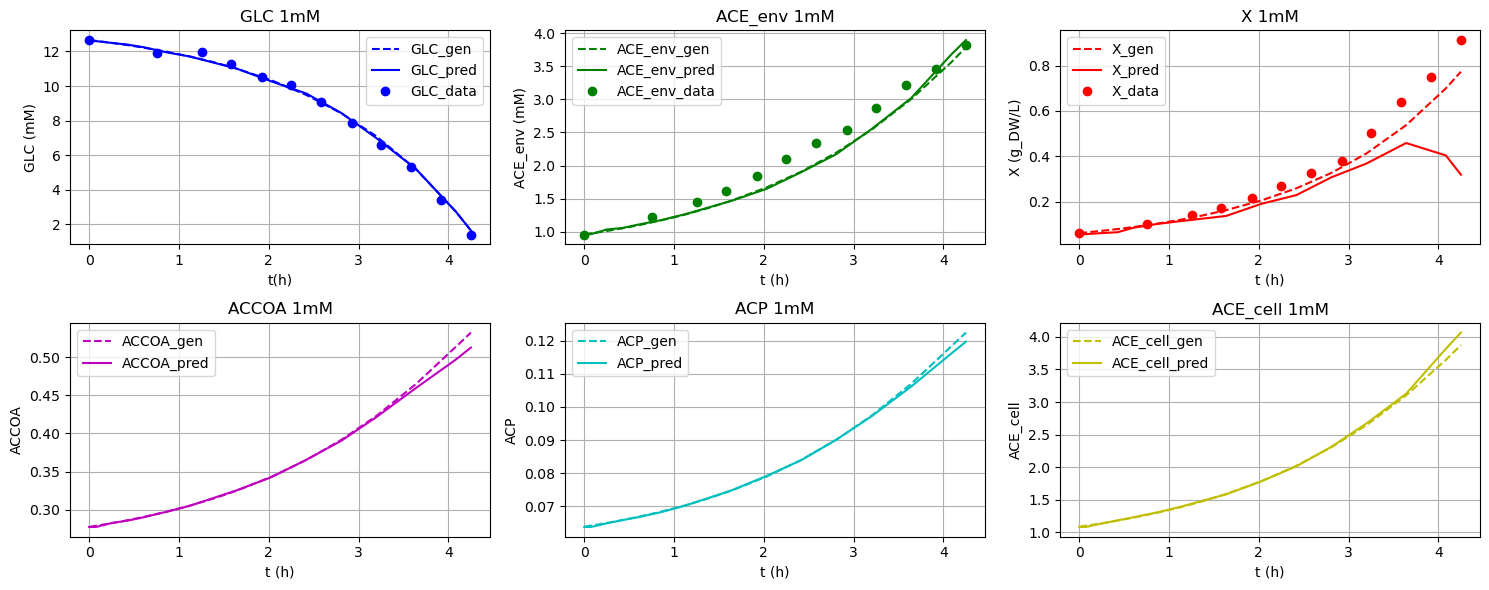

In [13]:
# Plot the predicted variables
fig, axs = plt.subplots(2, 3, figsize=(15, 6))

axs[0,0].plot(data_t, GLC, linestyle='dashed', label='GLC_gen', color='b')
axs[0,0].plot(data_t, GLC_pred.detach().numpy(), label='GLC_pred', color='b')
axs[0,0].plot(data_t_1, data_1[1:, 3], 'o', label='GLC_data', color='b')
axs[0,0].set_title('GLC 1mM')
axs[0,0].set_xlabel('t(h)')
axs[0,0].set_ylabel('GLC (mM)')
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].plot(data_t, ACE_env, linestyle='dashed', label='ACE_env_gen', color='g')
axs[0,1].plot(data_t, ACE_env_pred.detach().numpy(), label='ACE_env_pred', color='g')
axs[0,1].plot(data_t_1, data_1[1:, 1], 'o', label='ACE_env_data', color='g')
axs[0,1].set_title('ACE_env 1mM')
axs[0,1].set_xlabel('t (h)')
axs[0,1].set_ylabel('ACE_env (mM)')
axs[0,1].legend()
axs[0,1].grid(True)

axs[0,2].plot(data_t, X, linestyle='dashed', label='X_gen', color='r')
axs[0,2].plot(data_t, X_pred.detach().numpy(), label='X_pred', color='r')
axs[0,2].plot(data_t_1, data_1[1:, 2], 'o',label='X_data', color='r')
axs[0,2].set_title('X 1mM')
axs[0,2].set_xlabel('t (h)')
axs[0,2].set_ylabel('X (g_DW/L)')
axs[0,2].legend()
axs[0,2].grid(True)

axs[1,0].plot(data_t, ACCOA, linestyle='dashed', label='ACCOA_gen', color='m')
axs[1,0].plot(data_t, ACCOA_pred.detach().numpy(), label='ACCOA_pred', color='m')
axs[1,0].set_title('ACCOA 1mM')
axs[1,0].set_xlabel('t (h)')
axs[1,0].set_ylabel('ACCOA')
axs[1,0].legend()
axs[1,0].grid(True)

axs[1,1].plot(data_t, ACP, linestyle='dashed', label='ACP_gen', color='c')
axs[1,1].plot(data_t, ACP_pred.detach().numpy(), label='ACP_pred', color='c')
axs[1,1].set_title('ACP 1mM')
axs[1,1].set_xlabel('t (h)')
axs[1,1].set_ylabel('ACP')
axs[1,1].legend()
axs[1,1].grid(True)

axs[1,2].plot(data_t, ACE_cell, linestyle='dashed', label='ACE_cell_gen', color='y')
axs[1,2].plot(data_t, ACE_cell_pred.detach().numpy(), label='ACE_cell_pred', color='y')
axs[1,2].set_title('ACE_cell 1mM')
axs[1,2].set_xlabel('t (h)')
axs[1,2].set_ylabel('ACE_cell')
axs[1,2].legend()
axs[1,2].grid(True)

plt.tight_layout()
plt.show()

## Reconstruct values with learned parameters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


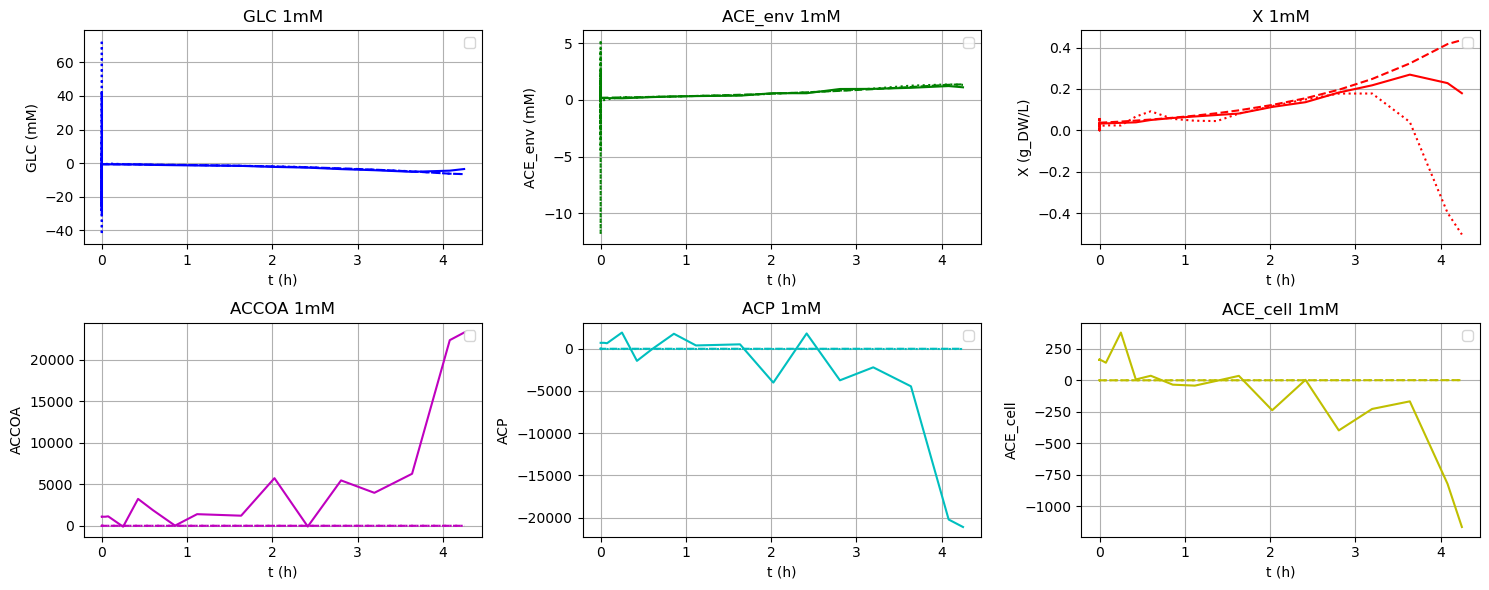

In [14]:
#Plot derivatives (dashed) and equations (full)
learned = DICT.copy()
learned = learned | dict(zip(parameter_names, learned_parameters))

y = np.array([GLC_pred.detach().numpy(),ACE_env_pred.detach().numpy(),X_pred.detach().numpy(),ACCOA_pred.detach().numpy(),ACP_pred.detach().numpy(),ACE_cell_pred.detach().numpy()])

fig, axs = plt.subplots(2, 3, figsize=(15, 6))

axs[0,0].plot(res.t, np.array([deriv_Millard(0,y[:,i],learned)[0] for i in range(len(res.t))]), color='b')
axs[0,0].plot(res.t, np.gradient(GLC,res.t), color='b', linestyle='dashed')
axs[0,0].plot(res.t, np.gradient(GLC_pred.detach().numpy(),res.t), color='b', linestyle=':')
axs[0,0].set_title('GLC 1mM')
axs[0,0].set_xlabel('t (h)')
axs[0,0].set_ylabel('GLC (mM)')
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].plot(res.t, np.array([deriv_Millard(0,y[:,i],learned)[1] for i in range(len(res.t))]), color='g')
axs[0,1].plot(res.t, np.gradient(ACE_env,res.t), color='g', linestyle='dashed')
axs[0,1].plot(res.t, np.gradient(ACE_env_pred.detach().numpy(),res.t), color='g', linestyle=':')
axs[0,1].set_title('ACE_env 1mM')
axs[0,1].set_xlabel('t (h)')
axs[0,1].set_ylabel('ACE_env (mM)')
axs[0,1].legend()
axs[0,1].grid(True)

axs[0,2].plot(res.t, np.array([deriv_Millard(0,y[:,i],learned)[2] for i in range(len(res.t))]), color='r')
axs[0,2].plot(res.t, np.gradient(X,res.t), color='r', linestyle='dashed')
axs[0,2].plot(res.t, np.gradient(X_pred.detach().numpy(),res.t), color='r', linestyle=':')
axs[0,2].set_title('X 1mM')
axs[0,2].set_xlabel('t (h)')
axs[0,2].set_ylabel('X (g_DW/L)')
axs[0,2].legend()
axs[0,2].grid(True)

axs[1,0].plot(res.t, np.array([deriv_Millard(0,y[:,i],learned)[3] for i in range(len(res.t))]), color='m')
axs[1,0].plot(res.t, np.gradient(ACCOA,res.t), color='m', linestyle='dashed')
axs[1,0].plot(res.t, np.gradient(ACCOA_pred.detach().numpy(),res.t), color='m', linestyle=':')
axs[1,0].set_title('ACCOA 1mM')
axs[1,0].set_xlabel('t (h)')
axs[1,0].set_ylabel('ACCOA')
axs[1,0].legend()
axs[1,0].grid(True)

axs[1,1].plot(res.t, np.array([deriv_Millard(0,y[:,i],learned)[4] for i in range(len(res.t))]), color='c')
axs[1,1].plot(res.t, np.gradient(ACP,res.t), color='c', linestyle='dashed')
axs[1,1].plot(res.t, np.gradient(ACP_pred.detach().numpy(),res.t), color='c', linestyle=':')
axs[1,1].set_title('ACP 1mM')
axs[1,1].set_xlabel('t (h)')
axs[1,1].set_ylabel('ACP')
axs[1,1].legend()
axs[1,1].grid(True)

axs[1,2].plot(res.t, np.array([deriv_Millard(0,y[:,i],learned)[5] for i in range(len(res.t))]), color='y')
axs[1,2].plot(res.t, np.gradient(ACE_cell,res.t), color='y', linestyle='dashed')
axs[1,2].plot(res.t, np.gradient(ACE_cell_pred.detach().numpy(),res.t), color='y', linestyle=':')
axs[1,2].set_title('ACE_cell 1mM')
axs[1,2].set_xlabel('t (h)')
axs[1,2].set_ylabel('ACE_cell')
axs[1,2].legend()
axs[1,2].grid(True)

plt.tight_layout()
plt.show()

In [15]:
# Integrate the Millard's model equations over the time grid
net_res = solve_ivp(fun=deriv_Millard,
                t_span=(0,4.25),
                y0=y_1_0,
                method='LSODA',
                args=(learned,),
                dense_output=True)

GLC_learned, ACE_env_learned, X_learned, ACCOA_learned, ACP_learned, ACE_cell_learned = net_res.y

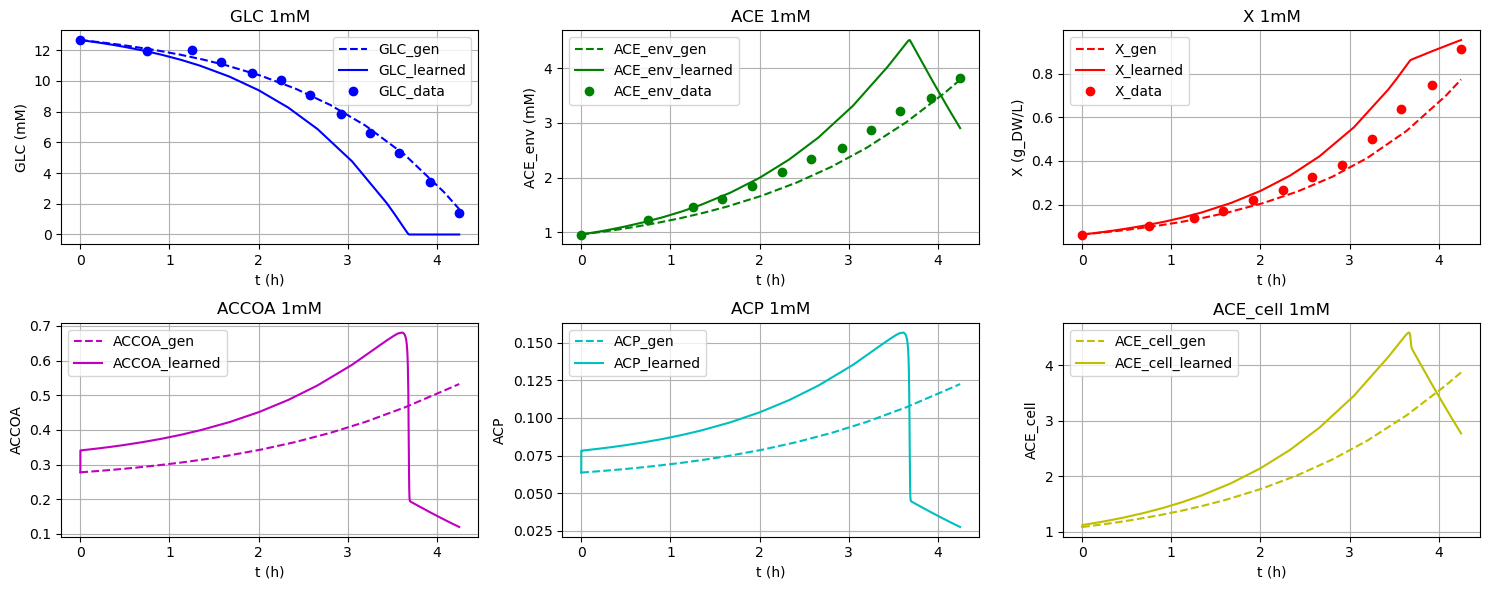

In [16]:
# Plot the solved variables
fig, axs = plt.subplots(2, 3, figsize=(15, 6))

axs[0,0].plot(data_t, GLC, linestyle='dashed', label='GLC_gen', color='b')
axs[0,0].plot(net_res.t, GLC_learned, label='GLC_learned', color='b')
axs[0,0].plot(data_t_1, data_1[1:, 3], 'o', label='GLC_data', color='b')
axs[0,0].set_title('GLC 1mM')
axs[0,0].set_xlabel('t (h)')
axs[0,0].set_ylabel('GLC (mM)')
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].plot(data_t, ACE_env, linestyle='dashed', label='ACE_env_gen', color='g')
axs[0,1].plot(net_res.t, ACE_env_learned, label='ACE_env_learned', color='g')
axs[0,1].plot(data_t_1, data_1[1:, 1], 'o', label='ACE_env_data', color='g')
axs[0,1].set_title('ACE 1mM')
axs[0,1].set_xlabel('t (h)')
axs[0,1].set_ylabel('ACE_env (mM)')
axs[0,1].legend()
axs[0,1].grid(True)

axs[0,2].plot(data_t, X, linestyle='dashed', label='X_gen', color='r')
axs[0,2].plot(net_res.t, X_learned,label='X_learned', color='r')
axs[0,2].plot(data_t_1, data_1[1:, 2], 'o',label='X_data', color='r')
axs[0,2].set_title('X 1mM')
axs[0,2].set_xlabel('t (h)')
axs[0,2].set_ylabel('X (g_DW/L)')
axs[0,2].legend()
axs[0,2].grid(True)

axs[1,0].plot(data_t, ACCOA, linestyle='dashed', label='ACCOA_gen', color='m')
axs[1,0].plot(net_res.t, ACCOA_learned, label='ACCOA_learned', color='m')
axs[1,0].set_title('ACCOA 1mM')
axs[1,0].set_xlabel('t (h)')
axs[1,0].set_ylabel('ACCOA')
axs[1,0].legend()
axs[1,0].grid(True)

axs[1,1].plot(data_t, ACP, linestyle='dashed', label='ACP_gen', color='c')
axs[1,1].plot(net_res.t, ACP_learned, label='ACP_learned', color='c')
axs[1,1].set_title('ACP 1mM')
axs[1,1].set_xlabel('t (h)')
axs[1,1].set_ylabel('ACP')
axs[1,1].legend()
axs[1,1].grid(True)

axs[1,2].plot(data_t, ACE_cell, linestyle='dashed', label='ACE_cell_gen', color='y')
axs[1,2].plot(net_res.t, ACE_cell_learned, label='ACE_cell_learned', color='y')
axs[1,2].set_title('ACE_cell 1mM')
axs[1,2].set_xlabel('t (h)')
axs[1,2].set_ylabel('ACE_cell')
axs[1,2].legend()
axs[1,2].grid(True)

plt.tight_layout()
plt.show()

In [17]:
# Print and compare parameters
from tools import param_error_percentages

print("Learned parameters :")
for i in range(len(learned_parameters)):
    print(parameter_names[i], ":", learned_parameters[i])

print()

print("True parameters :")
for i in range(len(learned_parameters)):
    print(parameter_names[i], ":", true_parameters[i])

print()

print("Parameters errors :")
for i in range(len(learned_parameters)):
    print(parameter_names[i], ":", param_error_percentages(true_parameters,learned_parameters)[i])



Learned parameters :
v_max_glycolysis : 6868.83740234375

True parameters :
v_max_glycolysis : 5557.64

Parameters errors :
v_max_glycolysis : 0.23592701260674487
